# ML Decision tree - replacing country with Lat/Lon

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. We have shown that good results can be achieved with a standard ML tree compared to the manually constructed iMeta tree algorithm, using the same three input features: country, maximum depth and year. 

We woukd also like to know whether other features might give a better result. There are also  some issues relating to country where some countries have no labelled profiles, which means the algorithm won't know what to do with that value for the country category. The expectation is the probe type is determined by country of origin, which means the country responsible for deploying the probe rather than the nearest country to where the probe was deployed, since different probes are sold in different markets. This notebook will look at whether there is a relationship between Latitude/Longitude and the probe type.

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [62]:
import joblib
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'azureml'

In [8]:
azure_working_root = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/xbt-test1/code/Users/stephen.haddad'

In [9]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
    'azureml': os.path.join(azure_working_root, 'xbt-data'),
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015),
    'azureml': (1966,2015),
}

In [10]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [11]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [14]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_root = os.path.join(root_data_dir, exp_out_dir_name)

In [12]:
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {'max_depth': 20,
                   'criterion':'gini',
                   'min_samples_leaf': 1,
                  }
classifier_name = 'decision_tree'
suffix='latLon'
exp_name = f'{classifier_name}_{suffix}'

In [15]:
xbt_output_dir = os.path.join(xbt_output_root, exp_name)
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)

In [16]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['max_depth', 'year', 'lat', 'lon']

In [17]:
output_fname = f'xbt_output_{exp_name}.csv'
output_clf_path = os.path.join(xbt_output_dir, output_fname)
result_fname = f'xbt_metrics_{exp_name}.csv'
result_path = os.path.join(xbt_output_dir, result_fname)
clf_fname = f'xbt_classifier_{exp_name}_0.joblib'
clf_path = os.path.join(xbt_output_dir, clf_fname)

In [19]:
if environment == 'azureml':
    from azureml.core import Workspace, Dataset

    # this info comes from the datastore info page in the Azure ML home area. There is example code on how to consume each datastore.
    subscription_id = '1fedcbc3-e156-45f5-a034-c89c2fc0ac61'
    resource_group = 'AWSEarth'
    workspace_name = 'stephenHaddad_xbt_europeWest'

    xbt_workspace = Workspace(subscription_id, resource_group, workspace_name)

    dataset = Dataset.get_by_name(xbt_workspace, name='xbt_input_files')
    dataset.download(target_path=xbt_input_dir, overwrite=False)
    

RuntimeError: File "/mnt/batch/tasks/shared/LS_root/mounts/clusters/xbt-test1/code/Users/stephen.haddad/xbt-data/csv_with_imeta/xbt_1966.csv" already exists. Set overwrite=True to overwrite it.

In [31]:
if environment == 'azureml':
    from azureml.core import Experiment
    experiment = Experiment(workspace=xbt_workspace, name=exp_name)

In [20]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 1min 39s, sys: 12.4 s, total: 1min 51s
Wall time: 11min 14s


## Data preparation

Data preparation is the same as for the standard imeta ML tree notebook, but with latitude and longitude replacing country code as an input feature. As previously the data is split into unseen, test and train for evaluating performance, and same hyper parameter values are used in decision tree. This time we are only using instrument as a target value, as there not shown to be benefit in training for model and manufacturer separately.

In [21]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 1.06 s, sys: 36.6 ms, total: 1.09 s
Wall time: 1.1 s


In [22]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [23]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [24]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 27 ms


In [25]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


In [26]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [27]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [28]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 8min 16s, sys: 20.6 s, total: 8min 37s
Wall time: 8min 37s


In [29]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We train the Decision tree classifier before and calculate F1, precision and recall for train, test and unseen sets, both for each class and averaged across classes.

We log information through the AzureML Run class:

Docs for the Run class: https://docs.microsoft.com/en-gb/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py

In [32]:
if environment == 'azureml':
    run = experiment.start_logging()
    run.log('classifier', classifier_name)
    for k1,v1 in classifier_opts.items():
        run.log(k1, v1)

In [33]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [34]:
%%time
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

CPU times: user 7.37 s, sys: 3.54 ms, total: 7.37 s
Wall time: 7.35 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].classes_)

In [36]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [37]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [38]:
y_res_unseen_instr_all = clf_dt_instr1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [39]:
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [40]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [41]:
if environment == 'azureml':
    run.log('metrics_instrument_per_class', df_metrics_per_class_instr)
    run.log('metrics_table', df_metrics_avg)

Save the results, both average and per class, to CSV files and register with the experiment framework where applicable.

In [42]:
result_per_class_fname = f'xbt_metrics_per_class_{exp_name}.csv'
result_per_class_path = os.path.join(xbt_output_dir, result_per_class_fname)
df_metrics_per_class_instr.to_csv(result_per_class_path)

result_avg_fname = f'xbt_metrics_avg_{exp_name}.csv'
result_avg_path = os.path.join(xbt_output_dir, result_avg_fname)
df_metrics_avg.to_csv(result_avg_path)

if environment == 'azureml':
    run.upload_file(name=result_per_class_fname,
                   path_or_stream=result_per_class_path)
    run.upload_file(name=result_avg_fname,
                   path_or_stream=result_avg_path)

In [44]:
if environment == 'azureml':
    run.log('recall_instr_train', df_metrics_avg[df_metrics_avg.target == 'instrument_train'].recall)
    run.log('recall_instr_test', df_metrics_avg[df_metrics_avg.target == 'instrument_test'].recall)
    run.log('recall_instr_unseen', df_metrics_avg[df_metrics_avg.target == 'instrument_unseen'].recall)

In [45]:
df_metrics_avg

,target,precision,recall,f1
0,instrument_train,0.980559,0.980511,0.980451
1,instrument_test,0.947534,0.947642,0.947522
2,instrument_unseen,0.910588,0.909514,0.909495


# Classification result plots

The plots below show the results for the whole XBT dataset. We see that the DT classifier performs well on the training data, but does not seem to generalise well. This especially true, as one would expect, for classes with very little support in the training dataset. Results are broadly comparable to using country as an input rather than lat/long. This suggests that if we are concerned about the problems with country code as an input feature, lat/long coordinate is a viable alternative.

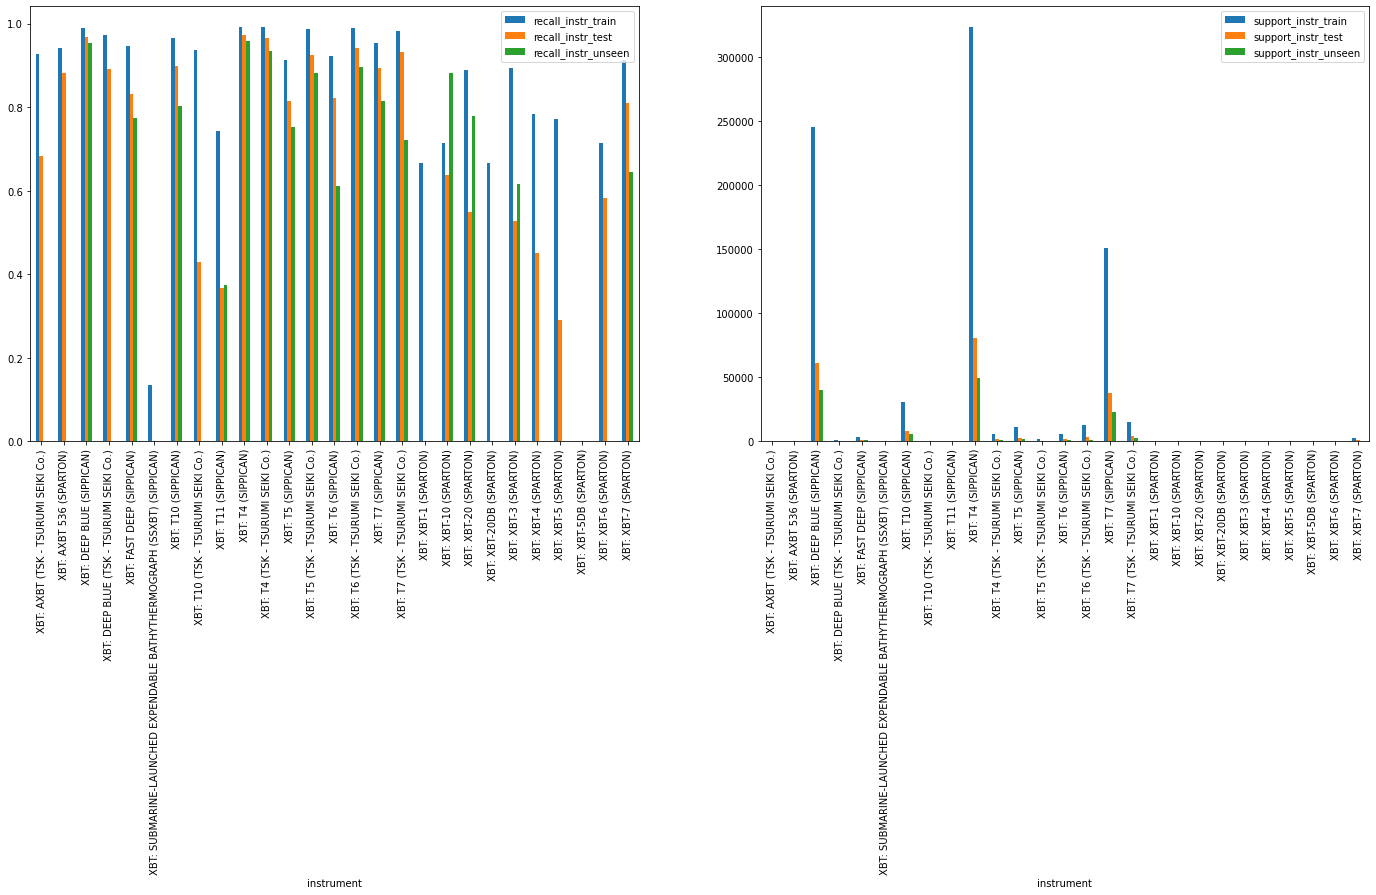

In [46]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,8))
axis_instr_metrics = fig_results_all_dt.add_subplot(121)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test','recall_instr_unseen'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(122)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'], ax=axis_instr_support)


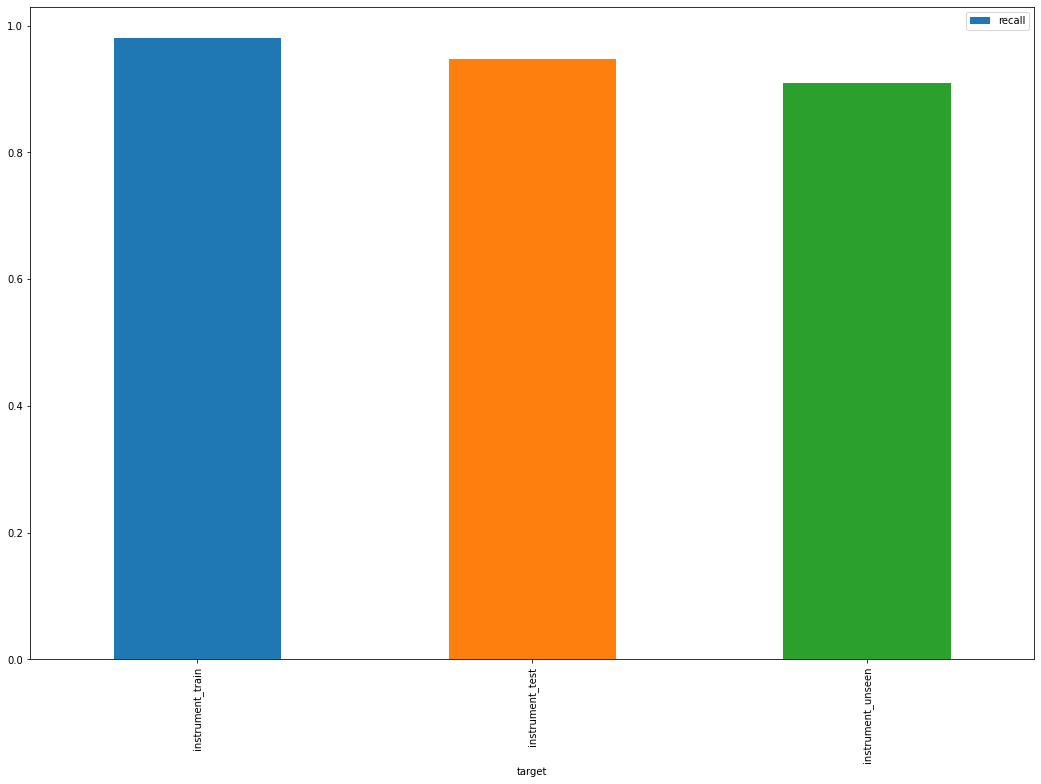

In [47]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train and test data for each year separetly and calculate the metrics year by year.

In [48]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    X_year = xbt_df.filter_obs({'year': year}, ).filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_df.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [49]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [50]:
results_by_year = {}

In [51]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_instr' : score_year(xbt_train_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_unseen_instr' : score_year(xbt_unseen, year, clf_dt_instr1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [52]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_instr' : [m1['metric_unseen_instr'][1] for y1,m1 in results_by_year.items()],
})


In [53]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [54]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [55]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [56]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

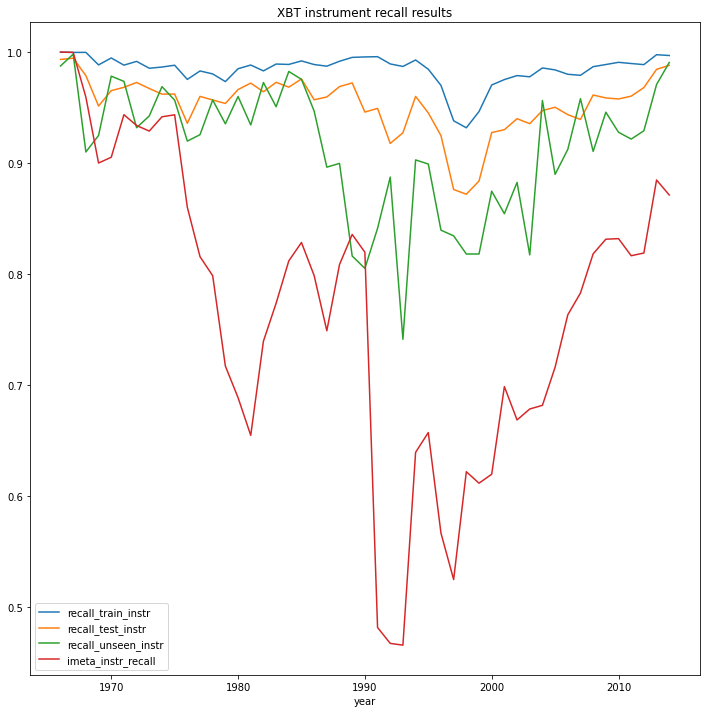

In [57]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(12,12))
ax_instr_recall_results = fig_model_recall_results.add_subplot(111, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'recall_unseen_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

The results for recall per year are again broadly comparable for this experiment where we use max depth, year and lat/long coordinate, compared to the original experiment where we used max depth, year and country code as the input features. This again supports lat/long coordinate as a viable alternative to country code.

In [58]:
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

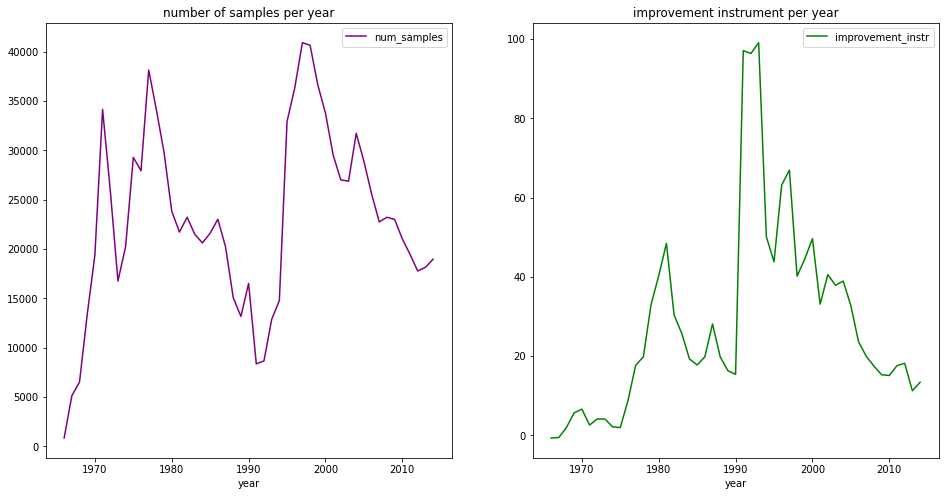

In [59]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,8))
ax_num_samples = fig_num_samples_per_year.add_subplot(121, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(122, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_instr'], c='green' )


In [60]:
results_df.to_csv(result_path)
if environment == 'azureml':
    run.upload_file(name=result_fname, 
                    path_or_stream=result_path
                   )

In [68]:
joblib.dump(clf_dt_instr1, clf_path)
if environment == 'azureml':
    run.upload_file(name=clf_fname, 
                    path_or_stream=clf_path
                   )
    model1 = run.register_model(model_name=f'xbt_skl_{exp_name}', model_path=clf_fname)    

AzureMLException: AzureMLException:
	Message: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.1159a4d1-e00a-44d9-a39b-f26c12b951a7/xbt_classifier_decision_tree_country_0.joblib already exists.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.1159a4d1-e00a-44d9-a39b-f26c12b951a7/xbt_classifier_decision_tree_country_0.joblib already exists."
    }
}

### Outputing the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [71]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [72]:
result_feature_name = 'instrument_res_dt'

In [ ]:
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [ ]:
res_ml1 = clf_dt_instr1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [ ]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [ ]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               feature_encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                               target_encoders={result_feature_name: xbt_labelled._target_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [81]:
xbt_full_dataset.output_data(output_clf_path,
                             target_features=[result_feature_name])

In [82]:
if environment == 'azureml':
    run.complete()

## Summary
We can see so far that the basic tree approach seems to be outperforming iMeta. Further work needs to be done to calculate these results more rigorously  using cross validation. 

The next step is to explore more sophisticated tree based approaches, such an ensemble of trees (random forest) and gredient-bossted tress (XGBoost),the current state of the art in tree methods.

There are also some issues with the dataset currently being used, so these results may change when the correct version of the data is being used.

In [83]:
exp_name

'decision_tree_country'